In [1]:
## imports
import os
import sys
import statistics as stat
from __future__ import print_function
from pathlib import Path
from collections import defaultdict
import nilmtk
from matplotlib import rcParams
from copy import deepcopy
import matplotlib.pyplot as plt
%matplotlib inline

## imports for the function 
import pandas as pd
import numpy as np
from typing import Union, Tuple, Dict
from nilmtk.utils import print_dict  
import json
from skimage.measure import block_reduce
from pprint import pprint

## path for load
sys.path.append(os.path.dirname(os.getcwd()))

## import for the load_data python
from src.unetnilm.data_proc import load_data
from src.stats.Statistical_analysis import extract_states, state_plot
from src.data_structures.sequence_mixer import RandomSequenceMixer

In [2]:
import src.functions as F

In [3]:
## dataset loading
from src.utils import paths_manager as pathsman

## Variable declaration for dataset
BUILDING = 1
START_TIME = "2015-01-01"
END_TIME = "2015-03-30"

## Dataset initialization
dataset = nilmtk.DataSet(pathsman.UKDALE_H5_PATH)
dataset.set_window(start=START_TIME, end=END_TIME)

In [4]:
#dataset.buildings[BUILDING].elec

In [5]:
# print(dataset.buildings[BUILDING].elec["fridge"])
# print(dataset.buildings[BUILDING].elec["washer dryer"])
# print(dataset.buildings[BUILDING].elec["toasted sandwich maker"])
# print(dataset.buildings[BUILDING].elec["dish washer"])
# print(dataset.buildings[BUILDING].elec["microwave"])

In [6]:
# dataset.buildings[BUILDING].elec["kettle"].plot()
# dataset.buildings[BUILDING].elec["toasted sandwich maker"].plot()
# dataset.buildings[BUILDING].elec["food processor"].plot()

In [7]:
# ## Initial/raw data plot
# dataset.buildings[BUILDING].elec["fridge"].plot()
# dataset.buildings[BUILDING].elec["washer dryer"].plot()
# dataset.buildings[BUILDING].elec["kettle"].plot()
# dataset.buildings[BUILDING].elec["dish washer"].plot()
# dataset.buildings[BUILDING].elec["microwave"].plot()

In [8]:
# dataset.buildings[BUILDING].elec["fridge"].power_series_all_data().plot()
# dataset.buildings[BUILDING].elec["washer dryer"].power_series_all_data().plot()
# dataset.buildings[BUILDING].elec["kettle"].power_series_all_data().plot()
# dataset.buildings[BUILDING].elec["dish washer"].power_series_all_data().plot()
# dataset.buildings[BUILDING].elec["microwave"].power_series_all_data().plot()

In [9]:
## Helper Functions

def binarization(data,threshold):
    """[summary]
    
    Arguments:
        data {[type]} -- [description]
        threshold {[type]} -- [description]
    
    Returns:
        [type] -- [description]
    """
    state = np.where(data>= threshold,1,0).astype(int)
    return state

def get_percentile(data,p=50):
    """[summary]
    
    Arguments:
        data {[type]} -- [description]
        quantile {[type]} -- [description]
    
    Returns:
        [type] -- [description]
    """
    return np.percentile(data, p, axis=1, interpolation="nearest")

def generate_sequences(sequence_length, data):
    sequence_length = sequence_length - 1 if sequence_length% 2==0 else sequence_length
    units_to_pad = sequence_length // 2
    new_mains = np.pad(data, (units_to_pad,units_to_pad),'constant',constant_values=(0,0))
    new_mains = np.array([new_mains[i:i + sequence_length] for i in range(len(new_mains) - sequence_length+1)])
    return new_mains

def quantile_filter(sequence_length, data, p=50):
    new_mains = generate_sequences(sequence_length, data)
    new_mains = get_percentile(new_mains, p)
    return new_mains

In [10]:
## Appliance Dictionary Declaration
building = 1
appliance = {
    "fridge" : {
        "window" : 50,
        "mean" : float(dataset.buildings[building].elec["fridge"].power_series_all_data().mean()),
        "std" : float(dataset.buildings[building].elec["fridge"].power_series_all_data().std()),
        "min" : float(dataset.buildings[building].elec["fridge"].power_series_all_data().min()),
        "max" : float(dataset.buildings[building].elec["fridge"].power_series_all_data().max())
    },
    "washer dryer" : {
        "window" : 50,
        "mean" : float(dataset.buildings[building].elec["washer dryer"].power_series_all_data().mean()),
        "std" : float(dataset.buildings[building].elec["washer dryer"].power_series_all_data().std()),
        "min" : float(dataset.buildings[building].elec["washer dryer"].power_series_all_data().min()),
        "max" : float(dataset.buildings[building].elec["washer dryer"].power_series_all_data().max())
    },
    "kettle" : {
        "window" : 10,
        "mean" : float(dataset.buildings[building].elec["kettle"].power_series_all_data().mean()),
        "std" : float(dataset.buildings[building].elec["kettle"].power_series_all_data().std()),
        "min" : float(dataset.buildings[building].elec["kettle"].power_series_all_data().min()),
        "max" : float(dataset.buildings[building].elec["kettle"].power_series_all_data().max())
    },
    "dish washer" : {
        "window" : 50,
        "mean" : float(dataset.buildings[building].elec["dish washer"].power_series_all_data().mean()),
        "std" : float(dataset.buildings[building].elec["dish washer"].power_series_all_data().std()),
        "min" : float(dataset.buildings[building].elec["dish washer"].power_series_all_data().min()),
        "max" : float(dataset.buildings[building].elec["dish washer"].power_series_all_data().max())
    },
    "microwave" : {
        "window" : 10,
        "mean" : float(dataset.buildings[building].elec["microwave"].power_series_all_data().mean()),
        "std" : float(dataset.buildings[building].elec["microwave"].power_series_all_data().std()),
        "min" : float(dataset.buildings[building].elec["microwave"].power_series_all_data().min()),
        "max" : float(dataset.buildings[building].elec["microwave"].power_series_all_data().max())
    }
}

In [11]:
power_elec = dataset.buildings[building].elec

indices = [power_elec[app].power_series_all_data().index for app in appliance.keys()]
sorted_indices = sorted(indices, key=len)

main_index = sorted_indices[0]
reduced_power_series_list = []

In [12]:
targets = []
states = [] 

for app in appliance.keys():
    power_series = power_elec[app].power_series_all_data()
    reduced_power_series = power_series[power_series.index.get_indexer(main_index, method="nearest")]
    reduced_power_series_list.append(reduced_power_series)
    meter = quantile_filter(appliance[app]["window"], reduced_power_series, p=50)
    state = binarization(meter, power_elec[app].on_power_threshold())
    targets.append(meter)
    states.append(state)

C:\Users\MTinaco\AppData\Local\Temp\ipykernel_14904\1755866677.py:26: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  return np.percentile(data, p, axis=1, interpolation="nearest")
C:\Users\MTinaco\AppData\Local\Temp\ipykernel_14904\1755866677.py:26: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  return np.percentile(data, p, axis=1, interpolation="nearest")
C:\Users\MTinaco\AppData\Local\Temp\ipykernel_14904\1755866677.py:26: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'l

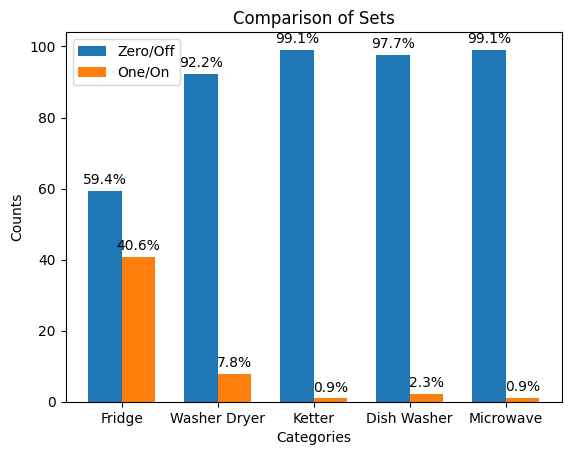

In [13]:
zero, one = extract_states(states)
state_plot(zero, one)

## With Data Shuffler

In [14]:
def quantile_filter_2(sequence_length, data, p=50):
    new_mains = F.scan_sequences(data=data, mode="odd_window", seq_len=sequence_length)
    new_mains = np.percentile(new_mains, p, axis=1, interpolation="nearest")
    return new_mains

In [15]:
FRIDGE_FREEZER = "fridge freezer"
KETTLE = "kettle"
DISHWASHER = "dish washer"
MICROWAVE = "microwave"
WASHER_DRYER = "washer dryer"

applist = [FRIDGE_FREEZER, WASHER_DRYER, KETTLE, DISHWASHER, MICROWAVE]

In [16]:
print(f"Activation stats in the period [{START_TIME}, {END_TIME}]")
row = []

for app in applist:
    col = []
    app_name = app.upper()
    activations = power_elec[app].get_activations()
    total_num = len(activations)
    average_length = stat.mean(map(len, activations))
    max_length = max(map(len, activations))
    min_length = min(map(len, activations))
    col.append(total_num)
    col.append(average_length)
    col.append(max_length)
    col.append(min_length)
    row.append(col)

pd.DataFrame(row, columns=["No. of Activations", "Average Length", "Max Length", "Min Length"], index=applist)

Activation stats in the period [2015-01-01, 2015-03-30]


,No. of Activations,Average Length,Max Length,Min Length
fridge freezer,2092,249.163958,3570,53
washer dryer,98,1008.918367,1308,246
kettle,458,27.174672,103,7
dish washer,31,1086.935484,1181,598
microwave,804,18.865672,142,7


In [17]:
def collect_sequence(appliance, num_windows, seq_len=100, mode="adaptive"):
        collections = []
        for activation in power_elec[appliance].get_activations():
                collections = collections + F.scan_sequences(np.array(activation), seq_len=seq_len, num_windows=num_windows, mode=mode)
        return collections

In [18]:
info = {
        FRIDGE_FREEZER : {
                "filter_window" : 50,
                "window" : (5, 5),
                "mode" : "tail",
                "min" : 0,
                "max" : 0,
        },
        WASHER_DRYER : {               
                "filter_window" : 50,
                "window" : 23,
                "mode" : "adaptive",
                "min" : 0,
                "max" : 0,
        },
        KETTLE : {
                "filter_window" : 50,
                "window" : 5,
                "mode" : "adaptive",
                "min" : 0,
                "max" : 0,
        },
        DISHWASHER : {
                "filter_window" : 10,
                "window" : 70,
                "mode" : "adaptive",
                "min" : 0,
                "max" : 0,
        },
        MICROWAVE : {
                "filter_window" : 50,
                "window" : 3,
                "mode" : "adaptive",
                "min" : 0,
                "max" : 0,
        }
}
targets_store = defaultdict(list)

for app in applist:
        collected_sequences = collect_sequence(app, num_windows=info[app]["window"], mode=info[app]["mode"])
        info[app]["Total collected sequences"] = len(collected_sequences)
        targets_store[app] = collected_sequences

pd.DataFrame(info)

,fridge freezer,washer dryer,kettle,dish washer,microwave
filter_window,50,50,50,10,50
window,"(5, 5)",23,5,70,3
mode,tail,adaptive,adaptive,adaptive,adaptive
min,0.0,0.0,0.0,0.0,0.0
max,1856.0,3956.0,3629.0,3057.0,3180.0
Total collected sequences,20842,2150,2286,2160,2404


In [19]:
extended_targets_store = deepcopy(targets_store)

fridge_extender = collect_sequence(FRIDGE_FREEZER, num_windows=2, seq_len=100, mode= "window")
extended_targets_store[FRIDGE_FREEZER].extend(fridge_extender)

washer_extender = collect_sequence(FRIDGE_FREEZER, num_windows=(5, 5), seq_len=100, mode= "tail")
extended_targets_store[WASHER_DRYER].extend(washer_extender)

extended_targets_store[DISHWASHER].extend([np.zeros(100) for _ in range(1000)])
extended_targets_store[KETTLE].extend([np.zeros(100) for _ in range(1000)])
extended_targets_store[MICROWAVE].extend([np.zeros(100) for _ in range(1000)])

In [40]:
NUM_SAMPLES = 10000
SEQUENCE_LENGTH = 100
rsm = RandomSequenceMixer(*(extended_targets_store[app] for app in applist))

main_meter_array = np.zeros(NUM_SAMPLES*SEQUENCE_LENGTH)
submeter_container = [np.zeros(NUM_SAMPLES*SEQUENCE_LENGTH) for _ in range(len(applist))]

In [41]:
from concurrent.futures import ThreadPoolExecutor, wait
import time

with ThreadPoolExecutor(max_workers=3) as executor:
        # first_target, first_meter = rsm.get()

        for arr in range(NUM_SAMPLES):
                future = executor.submit(rsm.get)
                targets = future.result()[0]
                main_meter = future.result()[1]

                for idx, target in enumerate(targets):
                        submeter_container[idx][SEQUENCE_LENGTH*arr:SEQUENCE_LENGTH*(arr+1)] = target
                
                main_meter_array[SEQUENCE_LENGTH*arr:SEQUENCE_LENGTH*(arr+1)] = main_meter
        

In [42]:
targets = []
states = []

for i, app in enumerate(applist):
        meter = quantile_filter_2(info[app]["filter_window"], submeter_container[i], p=50)
        state = binarization(meter, power_elec[app].on_power_threshold())
        info[app]['min'] = meter.min()
        info[app]['max'] = meter.max()

        meter = (meter - info[app]['min'])/(info[app]['max'] - info[app]['min'])

        targets.append(meter)
        states.append(state)

C:\Users\MTinaco\AppData\Local\Temp\ipykernel_14904\2094214197.py:3: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  new_mains = np.percentile(new_mains, p, axis=1, interpolation="nearest")


In [ ]:
info

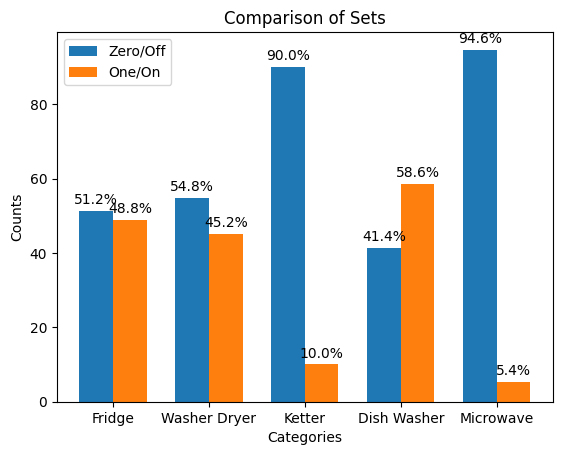

In [43]:
zero, one = extract_states(states)
state_plot(zero, one)

In [44]:
states = np.stack(states).T
targets = np.stack(targets).T

In [45]:
# for normalization
mains_max = power_elec.mains().power_series_all_data().max()
mains_min = power_elec.mains().power_series_all_data().min()

In [46]:
mains_denoise = quantile_filter_2(10, main_meter_array, 50)
mains = main_meter_array-np.percentile(main_meter_array, 1)
mains = np.where(mains < mains_denoise, mains_denoise, mains)
mains = quantile_filter_2(10, mains, 50)

C:\Users\MTinaco\AppData\Local\Temp\ipykernel_14904\2094214197.py:3: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  new_mains = np.percentile(new_mains, p, axis=1, interpolation="nearest")


In [47]:
norm_mains_denoise = (mains_denoise - mains_denoise.min())/(mains_denoise.max() - mains_denoise.min())
norm_mains = (mains - mains_min)/(mains_max - mains_min)

In [48]:
save_path = Path("to_dataloader/test2/")
save_path.mkdir(exist_ok=True)

In [49]:
np.save(str(save_path) + "/denoise_inputs.npy", norm_mains_denoise)
np.save(str(save_path) + "/noise_inputs.npy", norm_mains)
np.save(str(save_path) + "/targets.npy", targets)
np.save(str(save_path) + "/states.npy", states)